In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from helper import Helper as help

# Greedy vs Reluctant Step distribution analysis

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_J(N, dist):
    if dist == 'Gaussian':
        J = np.random.normal(0, 1/np.sqrt(N), size=(N, N))
        J = np.triu(J, 1)
        J = J + J.T
        np.fill_diagonal(J, 0)

    elif dist == 'Uniform':
        scale = np.sqrt(3) / np.sqrt(N)
        J = np.random.uniform(-scale, scale, size=(N, N))
        J = np.triu(J, 1)
        J = J + J.T
        np.fill_diagonal(J, 0)

    elif dist == 'Rademacher':
        J = np.random.choice([-1/np.sqrt(N), 1/np.sqrt(N)], size=(N, N))
        J = np.triu(J, 1)
        J = J + J.T
        np.fill_diagonal(J, 0)

    elif dist == 'Trimodal':
        # Vectorized implementation
        X = np.random.rand(N, N)
        J = np.zeros((N, N))
        mask1 = (X < 1/6)
        mask2 = (X >= 1/6) & (X < 1/3)
        J[mask1] = np.sqrt(3) / np.sqrt(N)
        J[mask2] = -np.sqrt(3) / np.sqrt(N)
        J = np.triu(J, 1)
        J = J + J.T
        np.fill_diagonal(J, 0)

    elif dist == 'Irrational':
        p_neg1 = np.sqrt(2) - 1 
        p_0 = 1 - (np.sqrt(2) / 2)
        p_root2 = 1 - p_neg1 - p_0
        values = np.array([-1/np.sqrt(N), 0, np.sqrt(2)/np.sqrt(N)])
        probs = np.array([p_neg1, p_0, p_root2])
        J = np.random.choice(values, size=(N, N), p=probs)
        J = np.triu(J, 1)
        J = J + J.T
        np.fill_diagonal(J, 0)
    else:
        raise ValueError("Unknown distribution")
    return J

def get_delta_E(J, sigma):
    # This is already vectorized and efficient
    return sigma * (2 * J @ sigma)

# Parameters
N = 100
n_trials = 5000
distributions = ['Gaussian', 'Uniform', 'Irrational', 'Rademacher', 'Trimodal']

# Store results
most_neg = {dist: [] for dist in distributions}
least_neg = {dist: [] for dist in distributions}
all_vals = {dist: [] for dist in distributions}

# Loop over distributions
for dist in distributions:
    for _ in range(n_trials):
        J = initialize_J(N, dist=dist)
        sigma = np.random.choice([-1, 1], size=N)
        delta_E = get_delta_E(J, sigma)
        negative_dE = delta_E[delta_E < 0]
        if negative_dE.size > 0:
            most_neg[dist].append(np.min(negative_dE))
            least_neg[dist].append(np.max(negative_dE))
            all_vals[dist].extend(negative_dE)


## Plot of rel and greedy steps

In [28]:
from scipy.stats import weibull_min, gumbel_l, expon, halfnorm

def plot_gaussian(ax, data, bins=50, color='r', label='N(0, 4)'):
    Z = -np.asarray(data)                
    loc, scale = halfnorm.fit(Z, floc=0) 
    x_vals = np.linspace(min(data), max(data), 400)
    y = halfnorm.pdf(-x_vals, loc=0, scale=scale)  
    lbl = fr"N(0, {scale**2:.2f})"
    ax.plot(x_vals, y, color=color, lw=1.5, label=lbl)

def plot_gumbel(ax, data, bins=50, color='r'):
    x_vals = np.linspace(min(data), max(data), 400)
    loc, scale = gumbel_l.fit(data)
    y_evt = gumbel_l.pdf(x_vals, loc=loc, scale=scale)
    lbl = f"Gumbel({loc:.2f}, {scale:.2f})"
    ax.plot(x_vals, y_evt, color=color, lw=1.5, label=lbl)

def plot_weibull(ax, data, bins=100, color='r'):
    Z = -np.asarray(data)
    x_vals = np.linspace(min(data), max(data), 400)
    c, loc, scale = weibull_min.fit(Z, floc=0.0)
    y_evt = weibull_min.pdf(-x_vals, c, loc=loc, scale=scale)
    lbl = f"Weibull({c:.2f}, {scale:.2f})"
    ax.plot(x_vals, y_evt, color=color, lw=1.5, label=lbl)

def plot_exponential(ax, data, bins=100, color='r'):
    Z = -np.asarray(data)
    loc, scale = expon.fit(Z, floc=0.0)   
    x_vals = np.linspace(min(data), max(data), 400)
    y_evt = expon.pdf(-x_vals, loc=loc, scale=scale)
    lbl = f"Exp(λ={scale:.2f})" # where lambda is scale ie 1/λ * exp(-x/λ)
    ax.plot(x_vals, y_evt, color=color, lw=1.5, label=lbl)

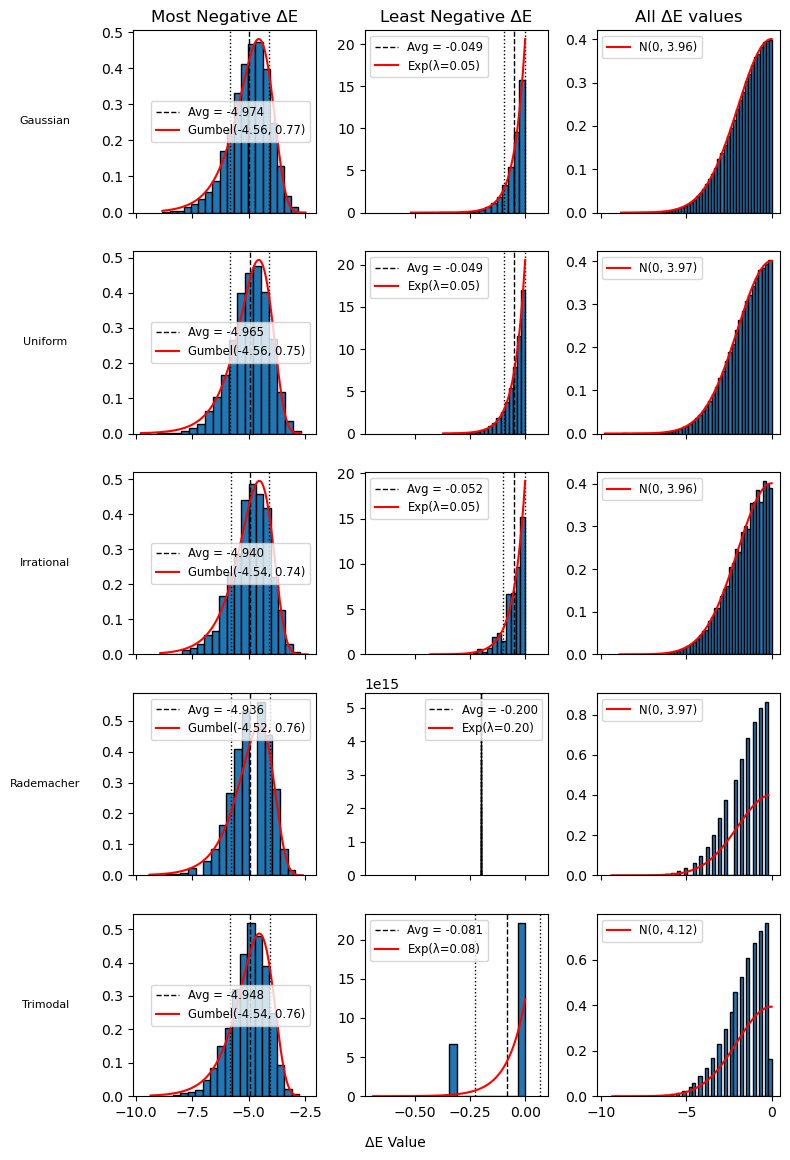

In [34]:
fig, axs = plt.subplots(5, 3, figsize=(8, 12), sharex='col')

axs[0, 0].set_title("Most Negative ΔE")
axs[0, 1].set_title("Least Negative ΔE")
axs[0, 2].set_title("All ΔE values")

for i, dist in enumerate(distributions):
    # Most Negative ΔE
    data_most = most_neg[dist]
    mean_most = np.mean(data_most)
    std_most = np.std(data_most)
    axs[i, 0].hist(data_most, bins=20, density=True, edgecolor='k')
    axs[i, 0].axvline(mean_most, color='k', linestyle='--', linewidth=1, label = f"Avg = {mean_most:.3f}")
    axs[i, 0].axvline(mean_most - std_most, color='k', linestyle=':', linewidth=1)
    axs[i, 0].axvline(mean_most + std_most, color='k', linestyle=':', linewidth=1)
    axs[i, 0].set_ylabel(f"{dist}", fontsize=8, rotation=0, labelpad=40, va='center')
    plot_gumbel(axs[i, 0], data_most)
    axs[i, 0].legend(fontsize='small')

    # Least Negative ΔE
    data_least = least_neg[dist]
    mean_least = np.mean(data_least)
    std_least = np.std(data_least)
    axs[i, 1].hist(data_least, bins=20, density=True, edgecolor='k')
    axs[i, 1].axvline(mean_least, color='k', linestyle='--', linewidth=1, label = f"Avg = {mean_least:.3f}")
    axs[i, 1].axvline(mean_least - std_least, color='k', linestyle=':', linewidth=1)
    axs[i, 1].axvline(mean_least + std_least, color='k', linestyle=':', linewidth=1)
    plot_exponential(axs[i, 1], data_least, bins=10)
    axs[i, 1].legend(fontsize='small')

    # All values
    axs[i, 2].hist(all_vals[dist], bins=50, density=True, edgecolor='k')
    plot_gaussian(axs[i, 2], all_vals[dist], bins=50)
    axs[i, 2].legend(fontsize='small')


fig.text(0.5, 0.04, "ΔE Value", ha='center')
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
